In [1]:
import torch
import torchvision
import torch.nn as nn
from torchvision import models, transforms
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from __future__ import division
import os
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'
%matplotlib inline

In [2]:
print(torch.cuda.is_available())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

True


In [3]:
def load_image(image_path, transform=None, max_size=None, shape=None):
    image = Image.open(image_path)
    if max_size:
        scale = max_size / max(image.size)
        size = np.array(image.size)* scale
        image = image.resize(size.astype(int), Image.ANTIALIAS)
    
    if shape:
        image = image.resize(shape, Image.LANCZOS)
        
    if transform:
        image = transform(image).unsqueeze(0)
        
    return image.to(device)

In [4]:
unloader = transforms.ToPILImage()
plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    
plt.figure()

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [5]:
transform = transforms.Compose([
    transforms.ToTensor()
])
content = load_image('../../data/input.png', transform, max_size=400)
style = load_image('../../data/style.png', transform, shape=[content.size(2), content.size(3)])

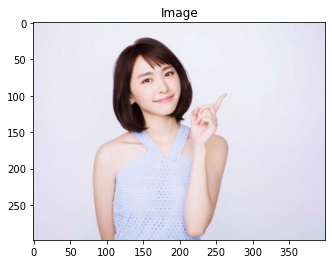

In [6]:
imshow(content[0], title='Image')

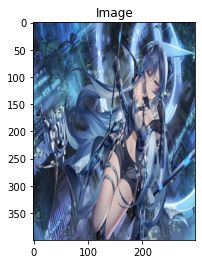

In [7]:
imshow(style[0], title='Image')

In [8]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])
content = load_image('../../data/input.png', transform, max_size=400)
style = load_image('../../data/style.png', transform, shape=[content.size(2), content.size(3)])

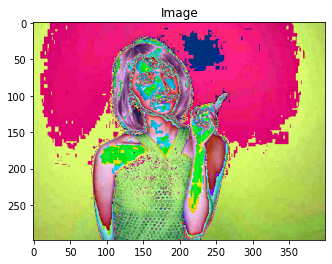

In [9]:
imshow(content[0], title='Image')

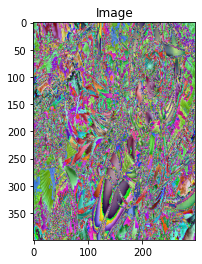

In [10]:
imshow(style[0], title='Image')

In [11]:
content.shape, style.shape

(torch.Size([1, 3, 298, 400]), torch.Size([1, 3, 400, 298]))

In [12]:
class VGG_Net(nn.Module):
    def __init__(self):
        super(VGG_Net, self).__init__()
        self.select = ['0', '5', '10', '19', '28']
        self.vgg = models.vgg19(pretrained=True).features
        
    def forward(self, x):
        features = []
        for name, layer in self.vgg._modules.items():
            x = layer(x)
            if name in self.select:
                features.append(x)
        return features

vgg = VGG_Net().to(device).eval()

In [13]:
# vgg = models.vgg19(pretrained=True)

In [14]:
# vgg.features

In [15]:
features = vgg(content)

In [16]:
# print(type(features))
# len(features)

In [17]:
for feat in features:
    print(feat.shape)

torch.Size([1, 64, 298, 400])
torch.Size([1, 128, 149, 200])
torch.Size([1, 256, 74, 100])
torch.Size([1, 512, 37, 50])
torch.Size([1, 512, 18, 25])


In [18]:
target = content.clone().requires_grad_(True)
optimizer = torch.optim.Adam([target], lr=0.003, betas=[0.5, 0.999])

In [19]:
total_step = 2000
for step in range(total_step):
    target_features = vgg(target)
    content_features = vgg(content)
    style_features = vgg(style)
    
    content_loss = style_loss = 0.
    for f1, f2, f3 in zip(target_features, content_features, style_features):
        content_loss += torch.mean((f1-f2)**2)
        _, c, h, w = f1.size()
        f1 = f1.view(c, h*w)
        f3 = f3.view(c, h*w)
        
        f1 = torch.mm(f1, f1.t())
        f3 = torch.mm(f3, f3.t())
        style_loss += torch.mean((f1-f3)**2) / (c*h*w)
        
    loss = content_loss + style_loss * 100.
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if step % 10 == 0:
        print('step [{}/{}], Content Loss: {:.4f}, Stype Loss: {:.4f}'.format(step, total_step, content_loss.item(), style_loss.item()))

step [0/2000], Content Loss: 0.0000, Stype Loss: 967.7647
step [10/2000], Content Loss: 5.8521, Stype Loss: 781.9473
step [20/2000], Content Loss: 10.7194, Stype Loss: 619.5739
step [30/2000], Content Loss: 14.0792, Stype Loss: 513.8315
step [40/2000], Content Loss: 16.6588, Stype Loss: 443.3321
step [50/2000], Content Loss: 18.6199, Stype Loss: 392.8212
step [60/2000], Content Loss: 20.1637, Stype Loss: 354.6797
step [70/2000], Content Loss: 21.3891, Stype Loss: 324.7910
step [80/2000], Content Loss: 22.3639, Stype Loss: 300.7613
step [90/2000], Content Loss: 23.1808, Stype Loss: 280.9231
step [100/2000], Content Loss: 23.8567, Stype Loss: 264.2766
step [110/2000], Content Loss: 24.4179, Stype Loss: 250.0470
step [120/2000], Content Loss: 24.8955, Stype Loss: 237.7314
step [130/2000], Content Loss: 25.2987, Stype Loss: 226.9448
step [140/2000], Content Loss: 25.6433, Stype Loss: 217.3835
step [150/2000], Content Loss: 25.9394, Stype Loss: 208.8336
step [160/2000], Content Loss: 26.204

step [1360/2000], Content Loss: 32.2766, Stype Loss: 38.9750
step [1370/2000], Content Loss: 32.2982, Stype Loss: 38.6275
step [1380/2000], Content Loss: 32.3214, Stype Loss: 38.2829
step [1390/2000], Content Loss: 32.3440, Stype Loss: 37.9410
step [1400/2000], Content Loss: 32.3654, Stype Loss: 37.6019
step [1410/2000], Content Loss: 32.3879, Stype Loss: 37.2655
step [1420/2000], Content Loss: 32.4106, Stype Loss: 36.9323
step [1430/2000], Content Loss: 32.4320, Stype Loss: 36.6019
step [1440/2000], Content Loss: 32.4515, Stype Loss: 36.2742
step [1450/2000], Content Loss: 32.4733, Stype Loss: 35.9497
step [1460/2000], Content Loss: 32.4943, Stype Loss: 35.6281
step [1470/2000], Content Loss: 32.5155, Stype Loss: 35.3096
step [1480/2000], Content Loss: 32.5383, Stype Loss: 34.9935
step [1490/2000], Content Loss: 32.5606, Stype Loss: 34.6803
step [1500/2000], Content Loss: 32.5816, Stype Loss: 34.3701
step [1510/2000], Content Loss: 32.6039, Stype Loss: 34.0629
step [1520/2000], Conten

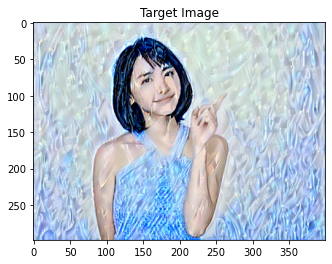

In [20]:
denorm = transforms.Normalize([-2.12, -2.04, -1.80], [4.37, 4.46, 4.44])
img = target.clone().squeeze()
img = denorm(img).clamp_(0, 1)
imshow(img, title='Target Image')